In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
emot_colnames = [
    'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 
    'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
mf_colnames = [
    'care', 'harm', 'fairness', 'cheating', 'loyalty', 
    'betrayal', 'authority', 'subversion', 'purity', 'degradation']
emot_mf_colnames = emot_colnames + mf_colnames

In [3]:
events = [("2020-01-26","Kobe Bryant's death",':'),
          ("2020-02-14","Valentine's Day",'--'),
          #('2020-03-14','WHO declares COVID a pandemic','-'),
          ('2020-03-14','COVID-19 pandemic','-'),
          #('2020-05-17','???','-'),
          ('2020-05-25','Black Lives Matter protest','-.')]

# Hourly and Daily Aggregated from ALL Data

In [4]:
df_hourly = pd.read_csv('../LA_data/LA_tweets_emot_mf_agg.csv',lineterminator='\n')
df_hourly['created_at'] = pd.to_datetime(df_hourly['created_at'])
df_hourly['date'] = df_hourly['created_at'].dt.round('D')
df_daily = df_hourly.groupby('date')[emot_mf_colnames+['count']].sum()
df_daily[emot_mf_colnames] = df_daily[emot_mf_colnames].div(df_daily['count'],axis=0)

In [5]:
df_daily.loc[pd.Timestamp('2020-01-01').tz_localize('utc')] = df_daily.loc[pd.Timestamp('2020-01-03').tz_localize('utc')]
df_daily.loc[pd.Timestamp('2020-01-02').tz_localize('utc')] = df_daily.loc[pd.Timestamp('2020-01-03').tz_localize('utc')]

# df_hourly.loc[pd.Timestamp('2020-01-01T00:00:00.000000000').tz_localize('utc')] = df_hourly.loc[pd.Timestamp('2020-01-03').tz_localize('utc')]
# df_hourly.loc[pd.Timestamp('2020-01-01T12:00:00.000000000').tz_localize('utc')] = df_hourly.loc[pd.Timestamp('2020-01-03').tz_localize('utc')]
# df_hourly.loc[pd.Timestamp('2020-01-02T00:00:00.000000000').tz_localize('utc')] = df_hourly.loc[pd.Timestamp('2020-01-03').tz_localize('utc')]
# df_hourly.loc[pd.Timestamp('2020-01-02T12:00:00.000000000').tz_localize('utc')] = df_hourly.loc[pd.Timestamp('2020-01-03').tz_localize('utc')]

In [6]:
df_daily = df_daily[df_daily.index<pd.Timestamp('2020-08-01',tz='utc')]

In [8]:
df_daily.to_csv('emotion_mf_time_series.csv')

# Plot Time Series

In [46]:
plt.cm.Set2.colors[3:6]

((0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961))

In [29]:
def plot_ts(df,columns,events=[],title=''):
    plt.figure()
    colors = ['coral','navy','turquoise','forestgreen','gold','darkviolet','sienna','grey']
    # colors = plt.cm.Set2.colors[3:6]+ ('crimson','dodgerblue','green','darksalmon','grey','mediumblue','darkviolet')
    for c,color in zip(columns,colors): 
        df[c].plot(figsize=[8,3],kind='line',color=color) # label=c,
    for e in events:
        plt.axvline(pd.Timestamp(e[0]),color='black',linestyle=e[2])#,label=e[1]
    plt.title(title,fontsize=15)
    plt.ylabel('Fraction of tweets',fontsize=13)
    plt.xticks(fontsize=11)
#     plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#       fancybox=True, shadow=True, ncol=4)

In [56]:
def plot_separate_ts(df,columns,events=[]):
    for c in columns:
        plt.figure()
        df[c].plot(figsize=[6,3],kind='line',color='black')
        for e in events:
            plt.axvline(pd.Timestamp(e[0]),label=e[1],color='red',linestyle=e[2])
        plt.title(c)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)
        plt.show()

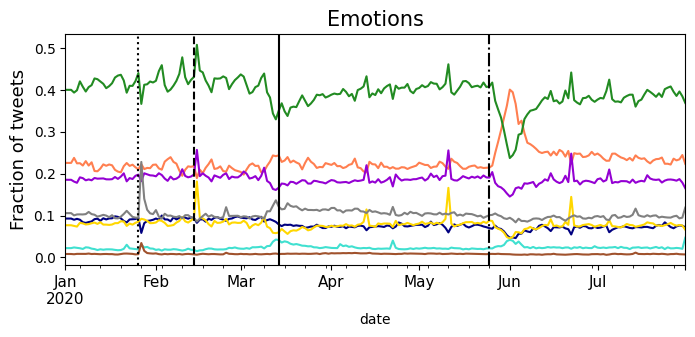

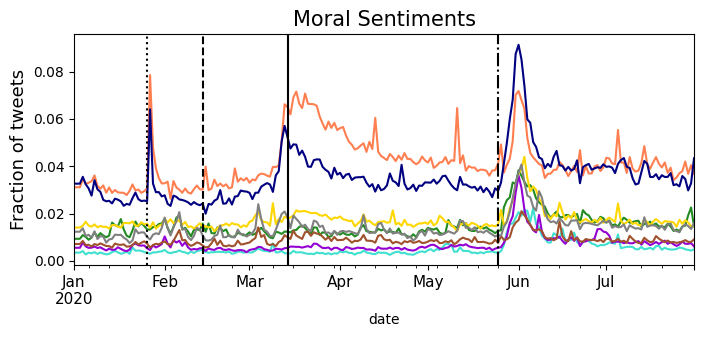

In [30]:
# plot time series in the same figure
plot_ts(df_daily,
        ['anger', 'anticipation', 'fear', 'joy', 'love', 
         'optimism', 'pessimism', 'sadness'], # 'surprise', 'trust'
        events = events,
        title='Emotions')

plot_ts(df_daily,
        ['care', 'harm', 'fairness', 'cheating', 'loyalty', 
         'betrayal', 'authority', 'subversion', 'purity', 'degradation'],
        events = events,
        title='Moral Sentiments')

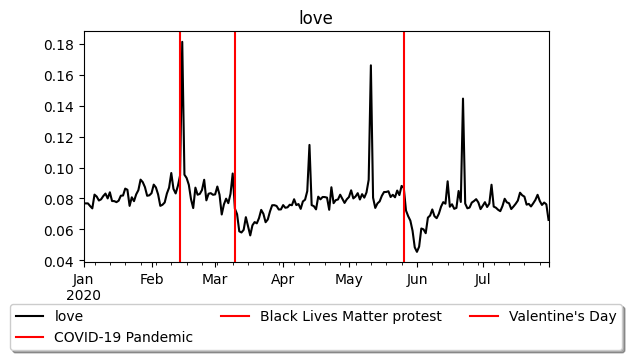

In [58]:
tmp_events = [('2020-03-10','COVID-19 Pandemic','-'),
             ('2020-05-26','Black Lives Matter protest','-'),
             ('2020-02-14',"Valentine's Day",'-')]
plot_separate_ts(df_daily,['love'],events=tmp_events) # emot_mf_colnames

# Change Point Detection

In [92]:
import kats
from kats.utils.decomposition import TimeSeriesDecomposition
from kats.consts import TimeSeriesData
from kats.detectors.cusum_detection import CUSUMDetector
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters

# use pyenv environment cpd_env, python version 3.9.17
# cpd_env_requirements_python_3_9_17.txt
# scipy version = 1.7.3
# pandas version = 1.3.5

def changepoint_detection(df,time_colname,var_colnames,title=''):
    changepoints = {}
    for c in var_colnames:
        # construct ts
        tmp_ts = df.reset_index()
        tmp_ts = tmp_ts[[time_colname,c]]
        tmp_ts[time_colname] = tmp_ts[time_colname].astype(str)
        tmp_ts.columns = ['time','value']
        ts = TimeSeriesData(tmp_ts)
        
        cp_list = []

        detector = BOCPDetector(ts)
        # BOCPD - assume normal distri
        cp_list.extend(detector.detector(
            model=BOCPDModelType.NORMAL_KNOWN_MODEL,
            changepoint_prior=0.1,
            threshold=0.6,
            agg_cp=True
        ))
#         # BOCPD - poisson
#         cp_list.extend(detector.detector(
#             model=BOCPDModelType.POISSON_PROCESS_MODEL
#         ))
#         # BOCPD - assume ordinary linear reg. 
#         cp_list.extend(detector.detector(
#             model=BOCPDModelType.TREND_CHANGE_MODEL,
#             model_parameters=TrendChangeParameters(
#                 readjust_sigma_prior=True, num_points_prior=14
#                 ),
#                 debug=True,
#                 threshold=0.6,
#                 choose_priors=False,
#                 agg_cp=True
#         ))
    
        # CUSUM - multiple change points
        historical_window = 14
        scan_window = 7
        step = 4
        cpts = []
        n = len(ts)
        for end_idx in range(historical_window + scan_window, n, step):
            tsd = ts[end_idx - (historical_window + scan_window) : end_idx]
            cpts += CUSUMDetector(tsd).detector(interest_window=[historical_window, historical_window + scan_window])
        
        # Plot the data, add results
        plt.figure(figsize=[20,3])
        plt.title(title+" - "+c)
        detector.plot(cp_list)
        plt.figure(figsize=[20,3])
        detector1 = CUSUMDetector(ts) # we are not really using this detector
        detector1.detector()
        detector1.plot(cpts)
        cp_list.extend(cpts)

        cleaned_list = []
        for j in cp_list:
            try:
                time = pd.Timestamp(j[0].start_time,tz='utc')
            except:
                time = pd.Timestamp(j[0].start_time)
            cleaned_list.append((time,j[0].confidence))
            # print(time, j[0].confidence)
        
        cleaned_list.sort(key=lambda x: x[0])
        idx_to_remove = []
        for j in range(1,len(cleaned_list)):
            if abs((cleaned_list[j][0] - cleaned_list[j-1][0]).days) <= 7:
                idx_to_remove.append(j)
        # print(idx_to_remove)
        cleaned_list = [item for idx,item in enumerate(cleaned_list) if idx not in idx_to_remove]
        print('finalized change points:')
        for tmp in cleaned_list:
            print(tmp[0].date(), round(tmp[1],4))
            
        changepoints[c] = cleaned_list
    return changepoints


def detect_event(time,events):
    for e in events:
        if time >= pd.Timestamp(e[0])-pd.Timedelta(1,unit='D') and time <= pd.Timestamp(e[0])+pd.Timedelta(1,unit='D'):
            event_date = e[0]
            return True,e
    return False,None


def measure_mean_change(df_ts,time_colname,var_colname,event_time,before_window=7,after_window=7):
    try:
        event_time = pd.Timestamp(event_time, tz='utc')
    except:
        event_time = pd.Timestamp(event_time)
    start_time = event_time - pd.Timedelta(before_window,unit='D')
    end_time = event_time + pd.Timedelta(after_window,unit='D')

    before_mean = df_ts.loc[(df_ts[time_colname]>=start_time) & (df_ts[time_colname]<event_time),var_colname].mean()
    after_mean = df_ts.loc[(df_ts[time_colname]>=event_time) & (df_ts[time_colname]<end_time),var_colname].mean()
    
    return (after_mean-before_mean)/before_mean*100


import statsmodels.formula.api as smf

def measure_rdd_change(df_ts,time_colname,var_colname,event_time,before_window=7,after_window=7,mode='kink',plot=True):
    if mode == 'jump':
        effect_coef = 'threshold'
    elif mode == 'kink':
        effect_coef = 'date_to_int:threshold'
    
    try:
        event_time = pd.Timestamp(event_time, tz='UTC')
    except:
        event_time = pd.Timestamp(event_time)
    start_time = event_time - pd.Timedelta(before_window,unit='D')
    end_time = event_time + pd.Timedelta(after_window,unit='D')
    
    df = df_ts[(df_ts[time_colname]>=start_time) & (df_ts[time_colname]<=end_time)]
    df = df.sort_index()
    df['date_to_int'] = list(range(len(df)))
    event_idx = df.loc[df[time_colname]==event_time,'date_to_int'].item()
    df['date_to_int'] = df['date_to_int'] - event_idx # make date_to_int of the event zero
    df = df.assign(threshold=(df['date_to_int'] > 0).astype(int))
    
    model = smf.wls("Q('"+var_colname+"')~date_to_int*threshold", df).fit()
    ate_pct = round(100*((model.params[effect_coef] + model.params["Intercept"])/model.params["Intercept"] - 1),2)

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



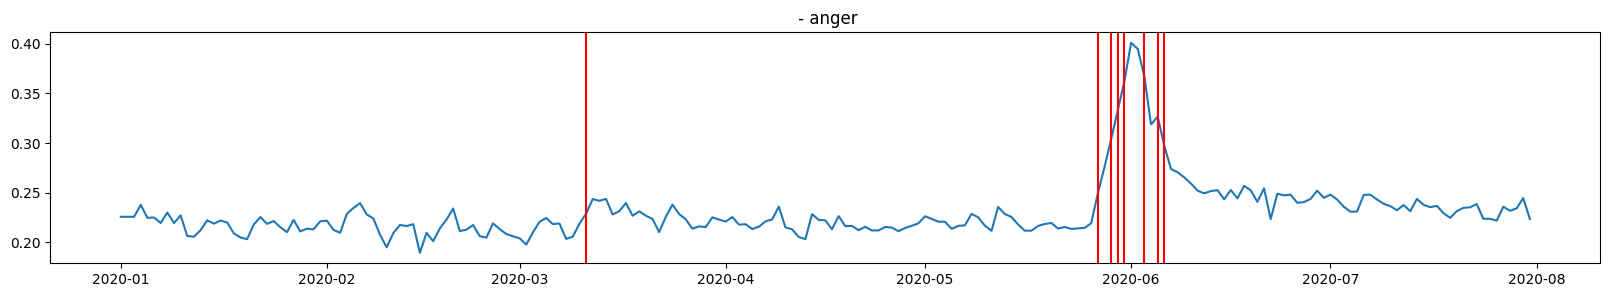

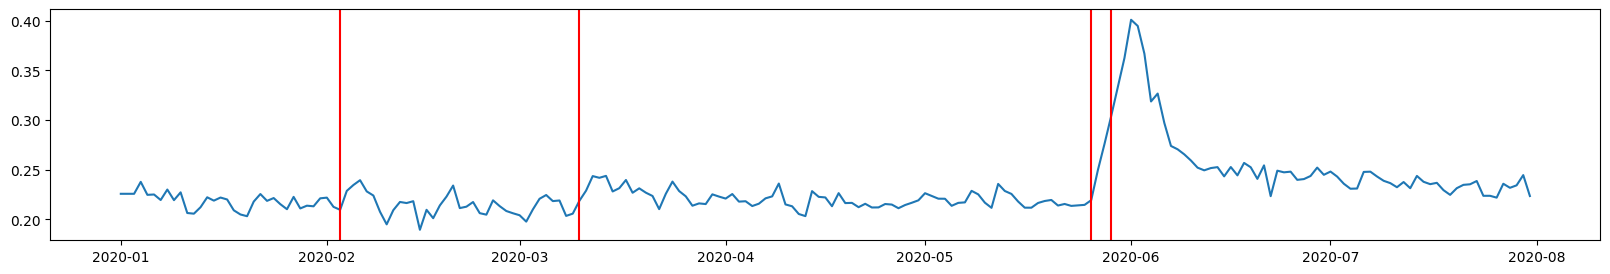

finalized change points:
2020-02-03 0.9998
2020-03-10 1.0
2020-05-26 1.0


/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



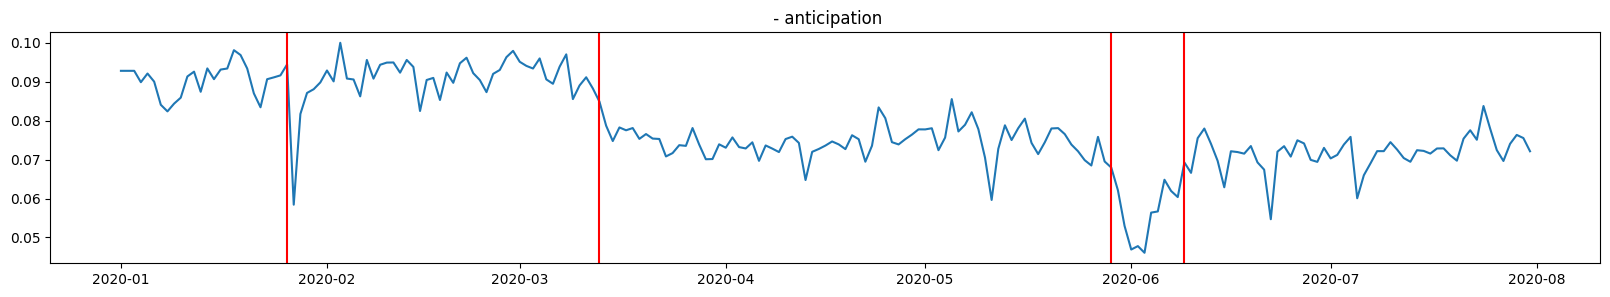

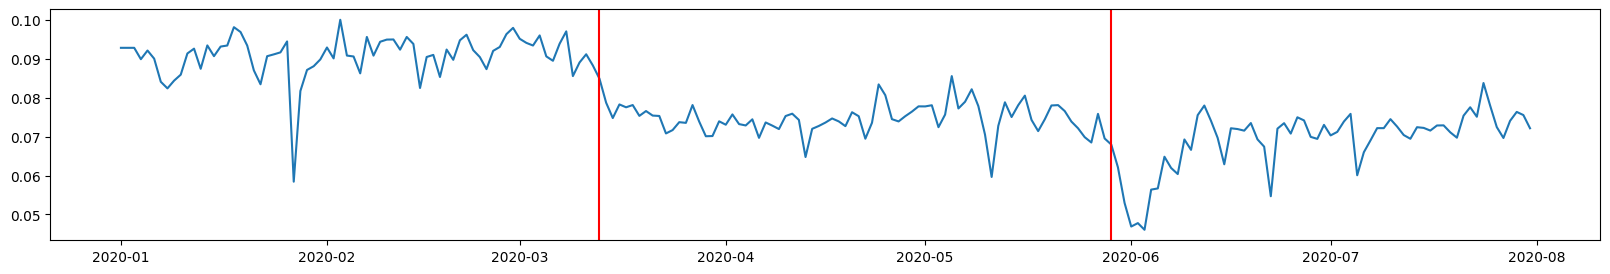

finalized change points:
2020-01-26 0.9798
2020-03-13 0.7217
2020-05-29 0.6947
2020-06-09 0.6225


/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



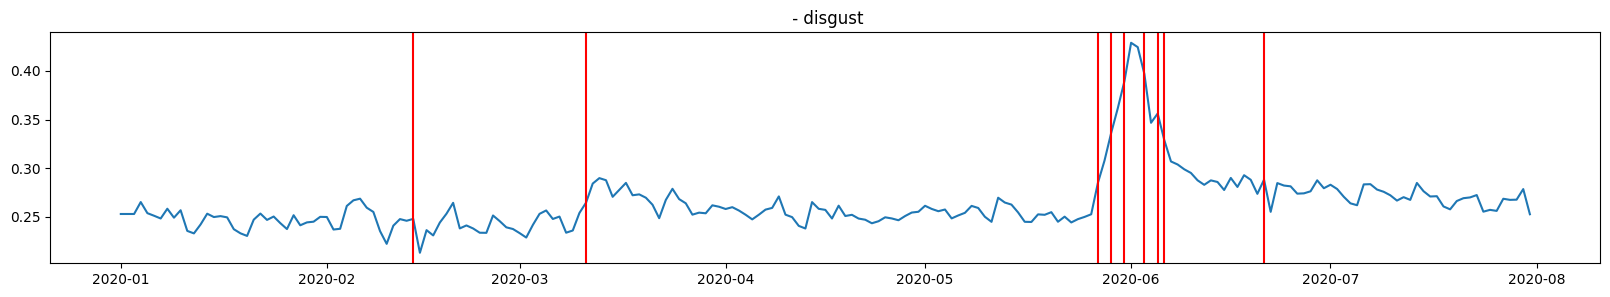

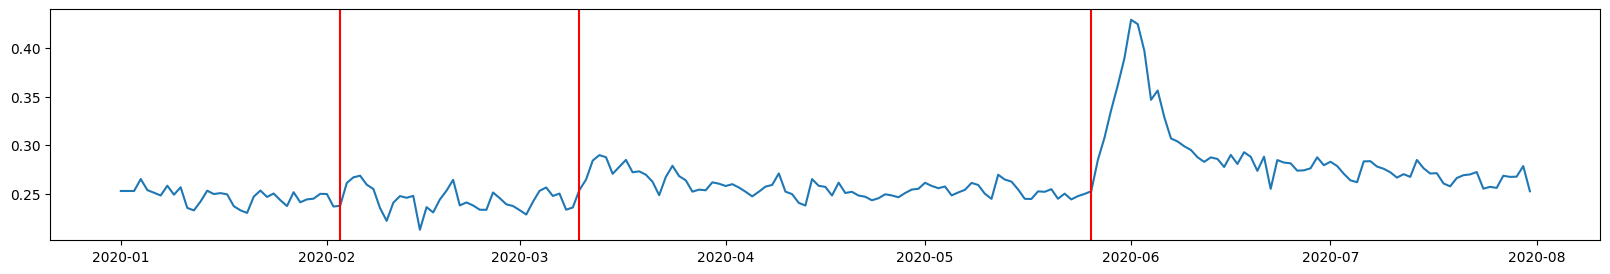

finalized change points:
2020-02-03 0.9999
2020-02-14 0.6761
2020-03-10 1.0
2020-05-26 1.0
2020-06-21 0.6124


/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



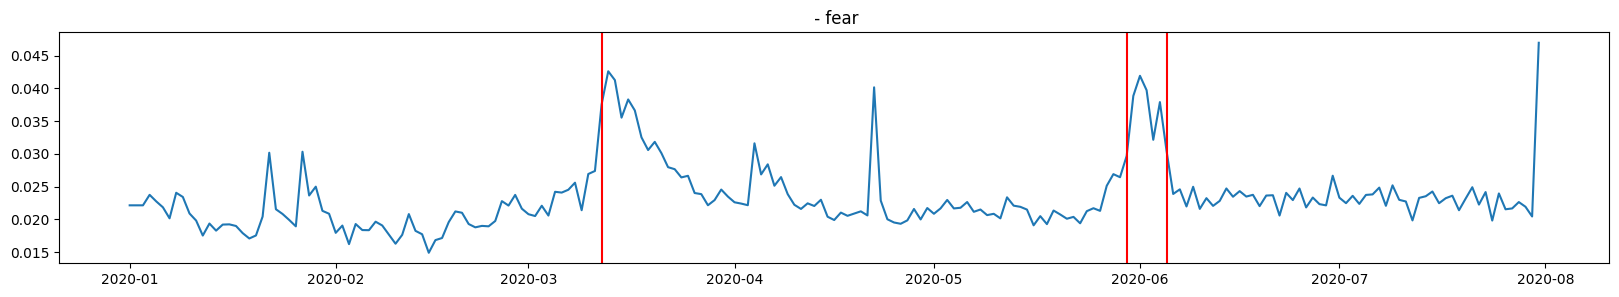

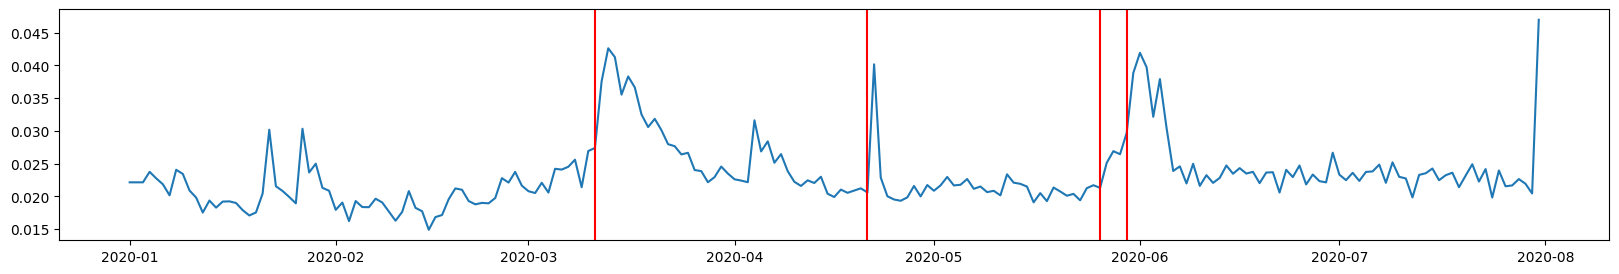

finalized change points:
2020-03-11 1.0
2020-04-21 0.9999
2020-05-26 1.0


/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



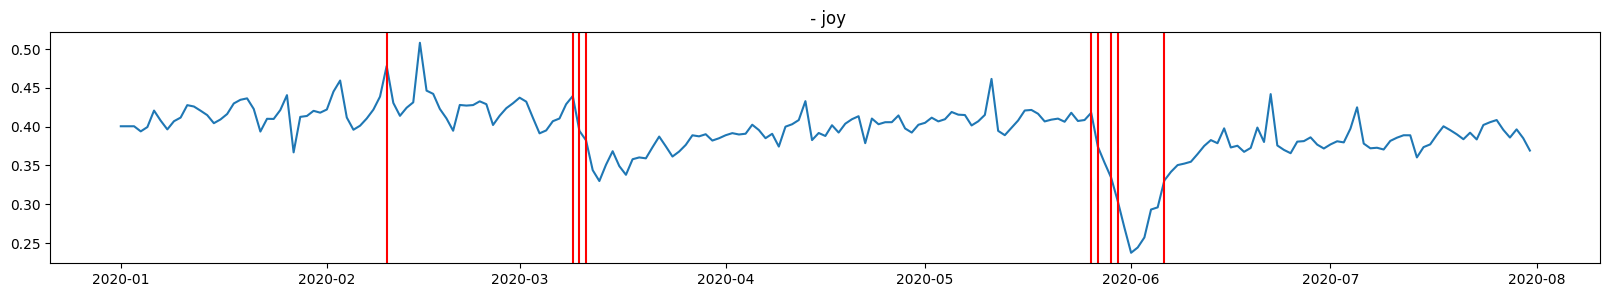

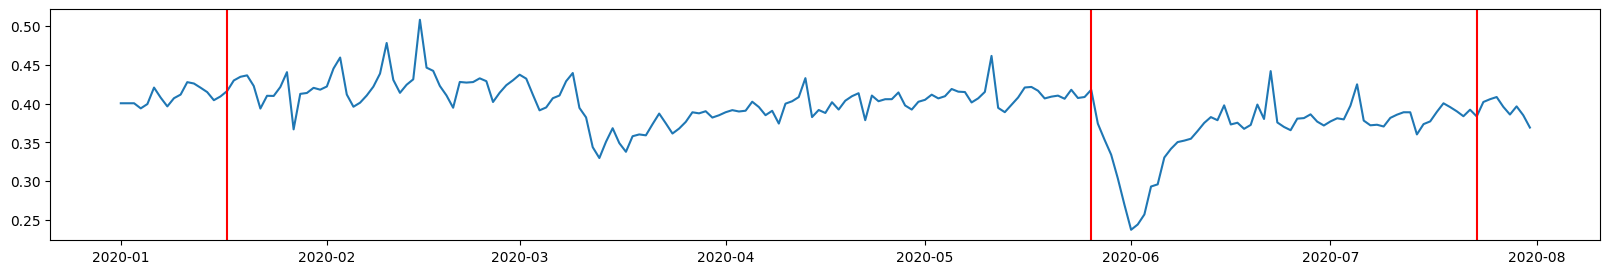

finalized change points:
2020-01-17 0.9981
2020-02-10 0.6517
2020-03-09 0.9689
2020-05-26 0.8353
2020-07-23 0.9968


/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



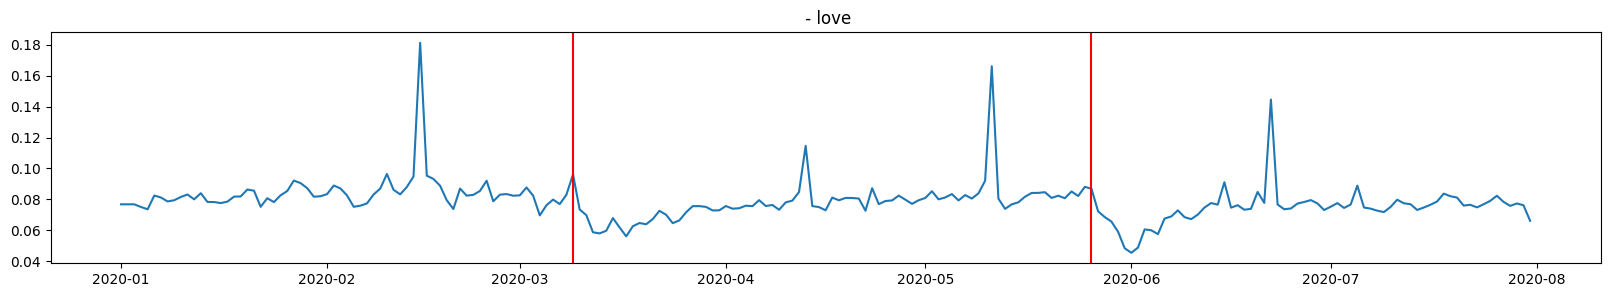

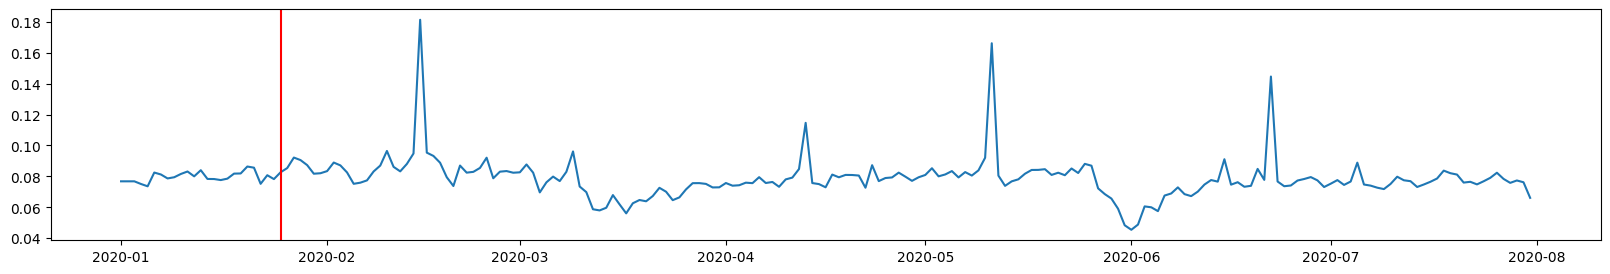

finalized change points:
2020-01-25 0.9998
2020-03-09 0.904
2020-05-26 0.6756


/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



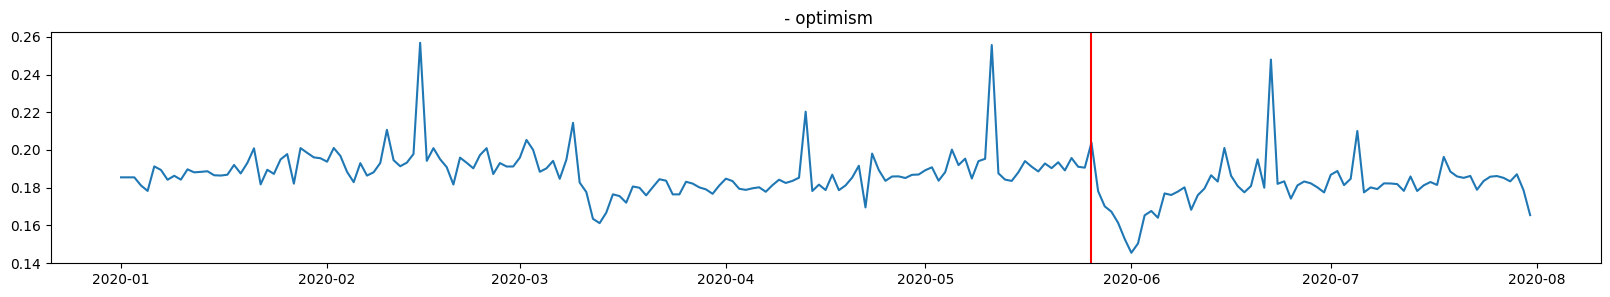

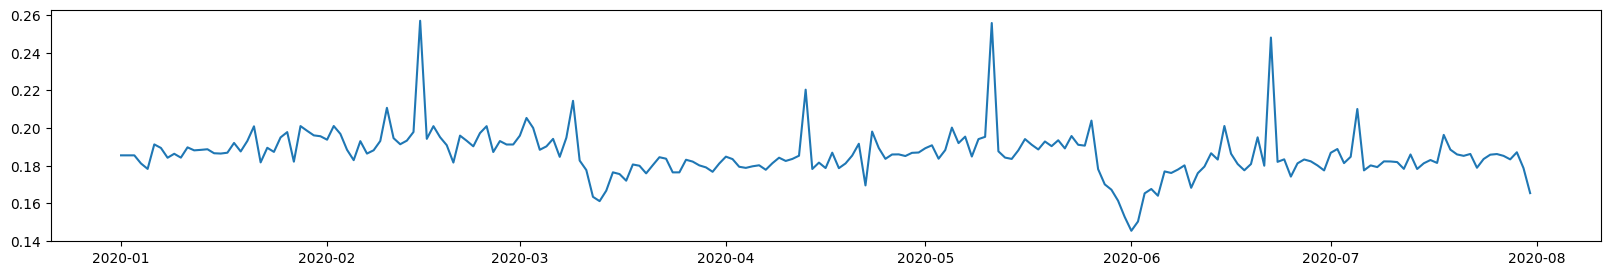

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



finalized change points:
2020-05-26 0.9957


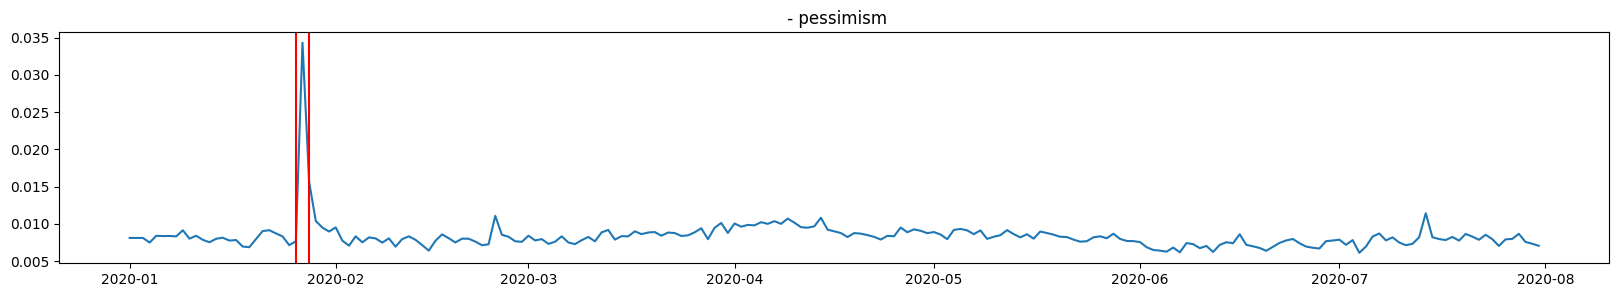

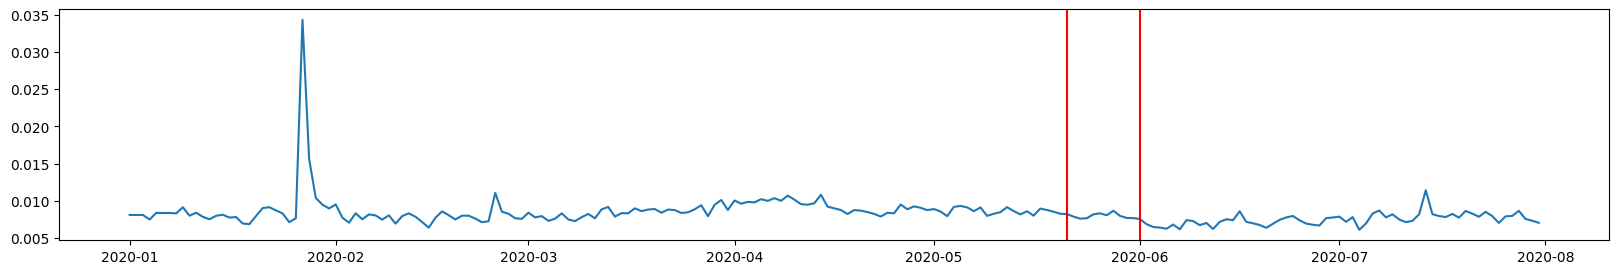

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



finalized change points:
2020-01-26 0.99
2020-05-21 0.9954
2020-06-01 1.0


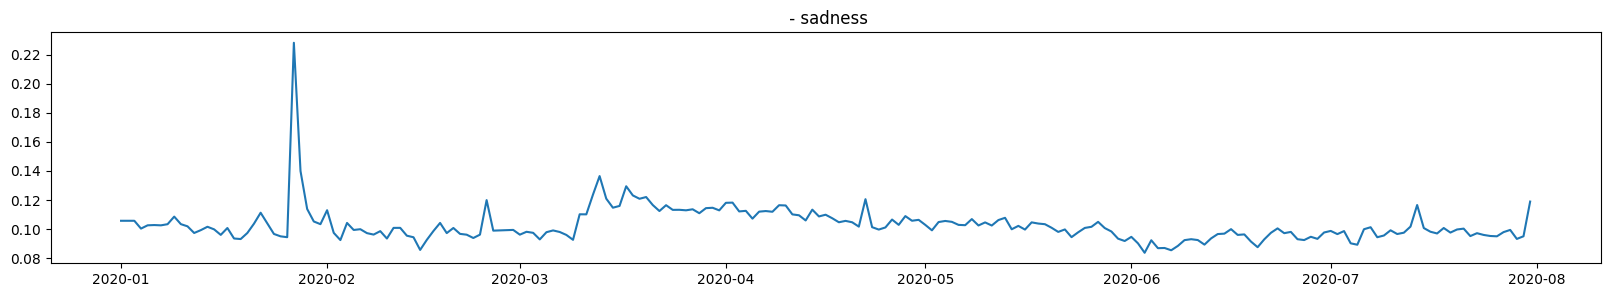

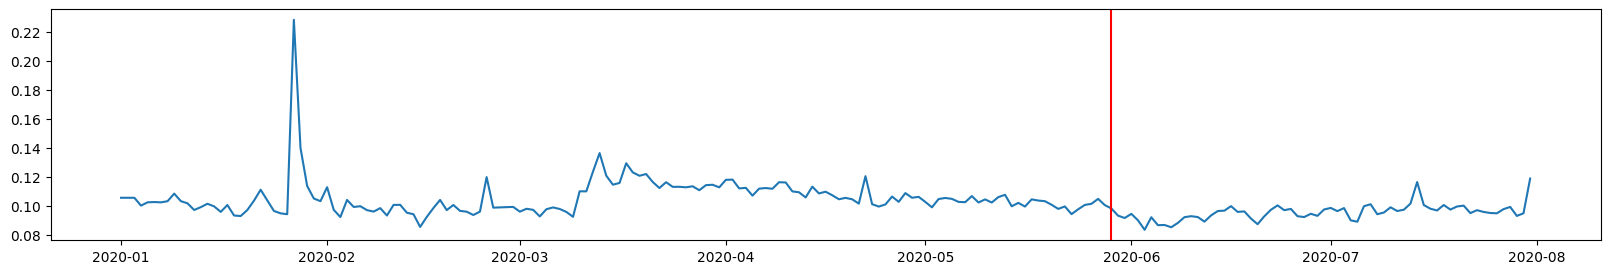

finalized change points:
2020-05-29 0.9986


/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



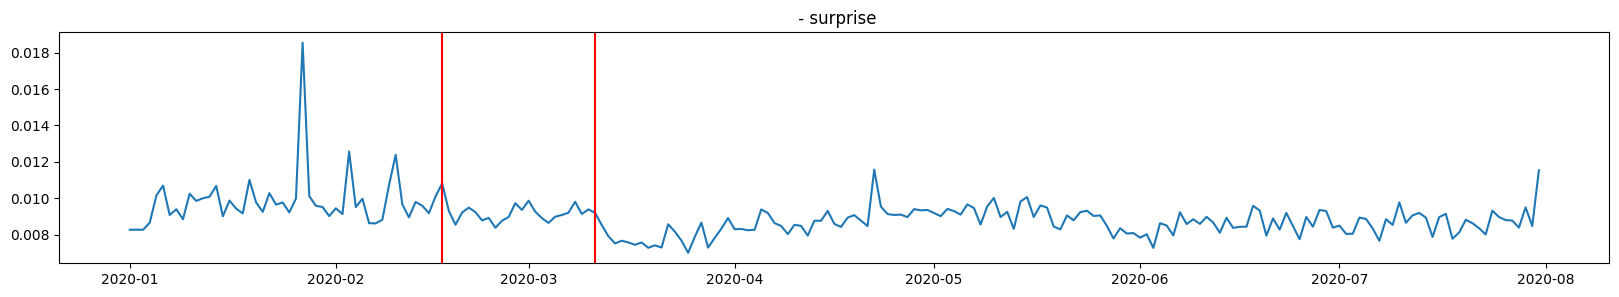

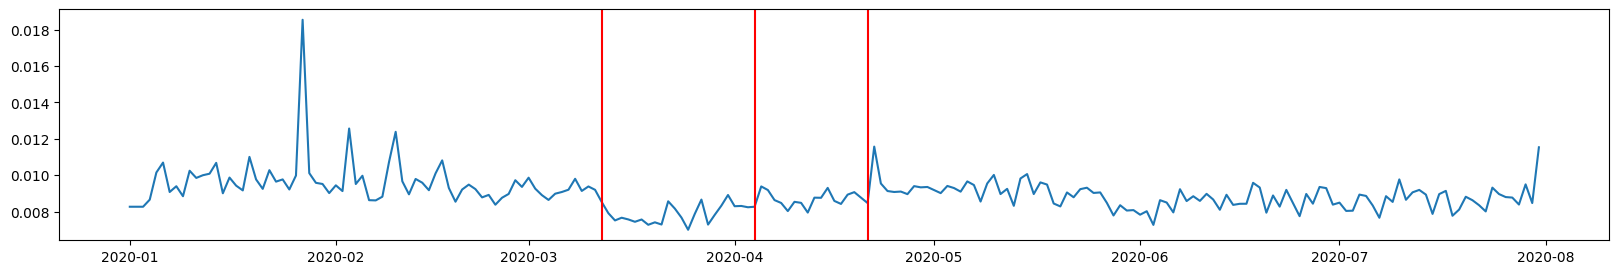

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



finalized change points:
2020-02-17 0.6783
2020-03-11 0.6538
2020-04-04 0.9935
2020-04-21 1.0


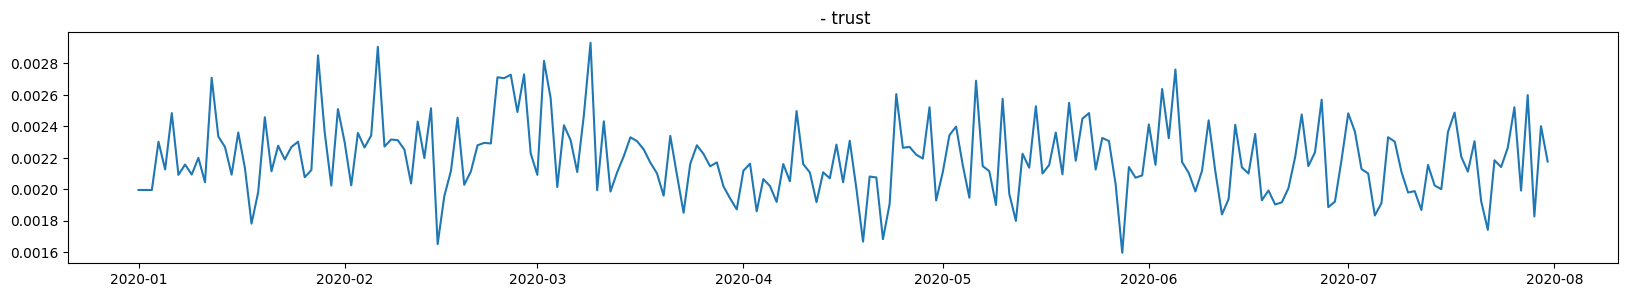

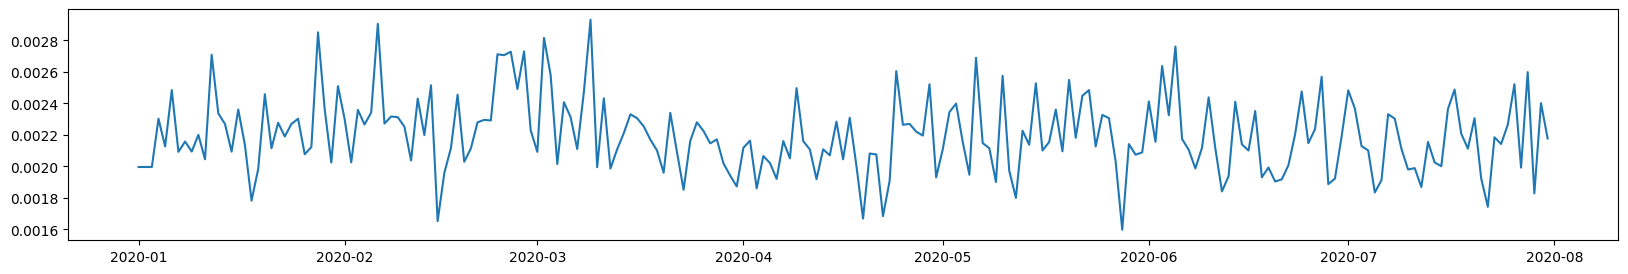

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



finalized change points:


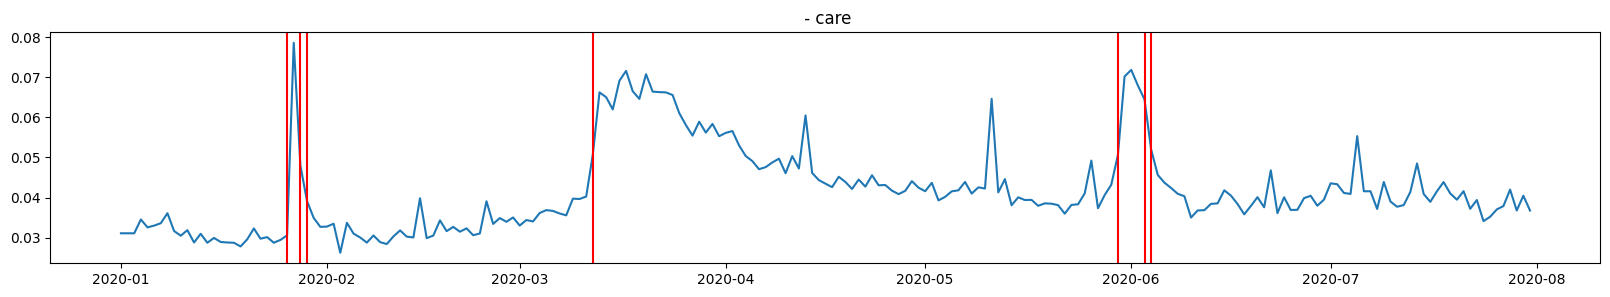

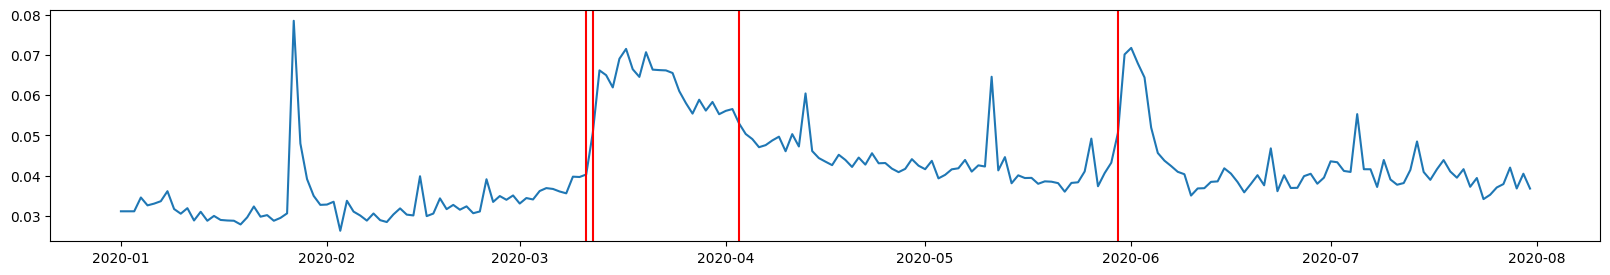

finalized change points:
2020-01-26 0.9897
2020-03-11 1.0
2020-04-03 0.9965
2020-05-30 0.9547


/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



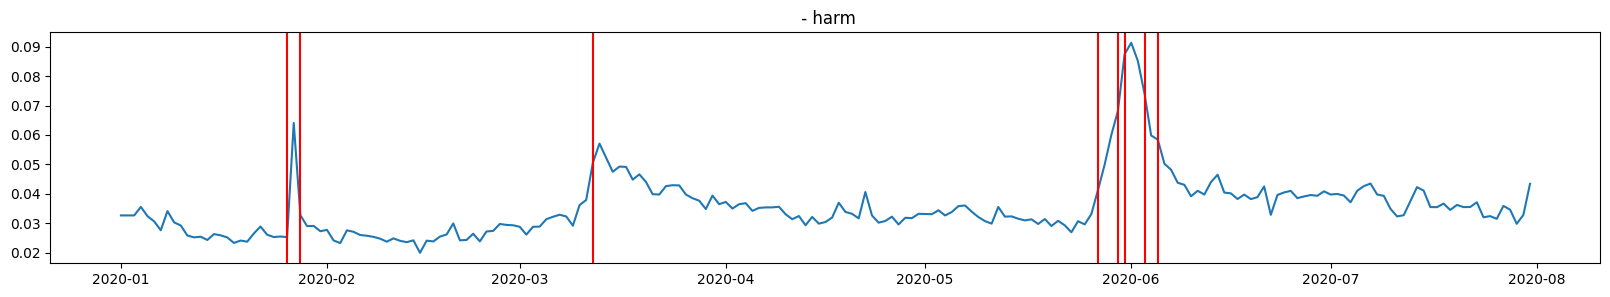

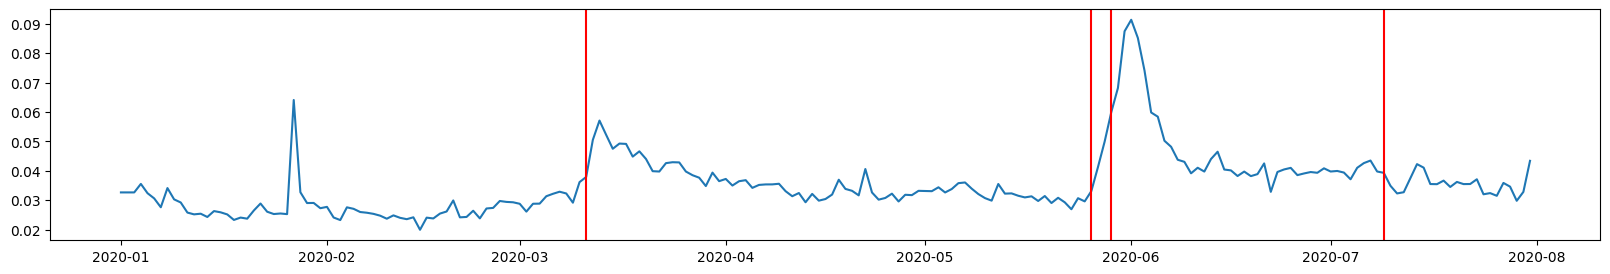

finalized change points:
2020-01-26 0.9792
2020-03-11 1.0
2020-05-26 1.0
2020-07-09 0.9967


/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



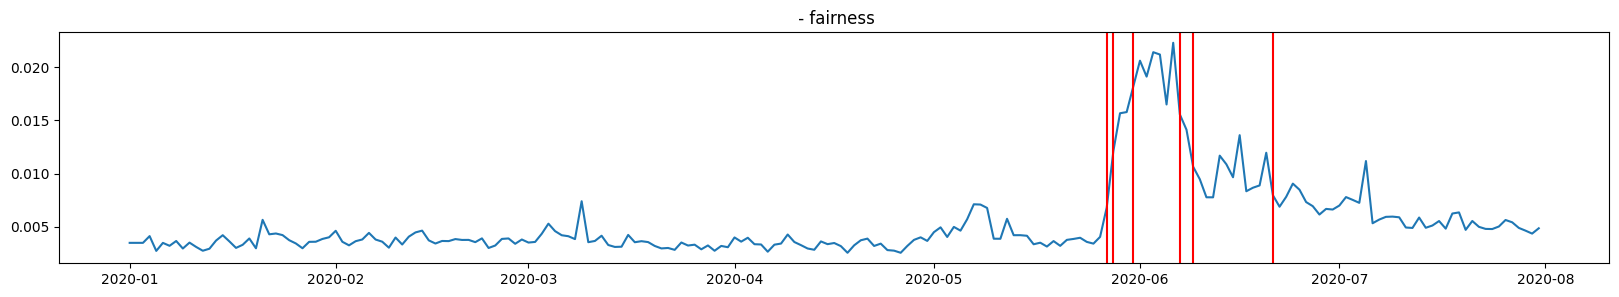

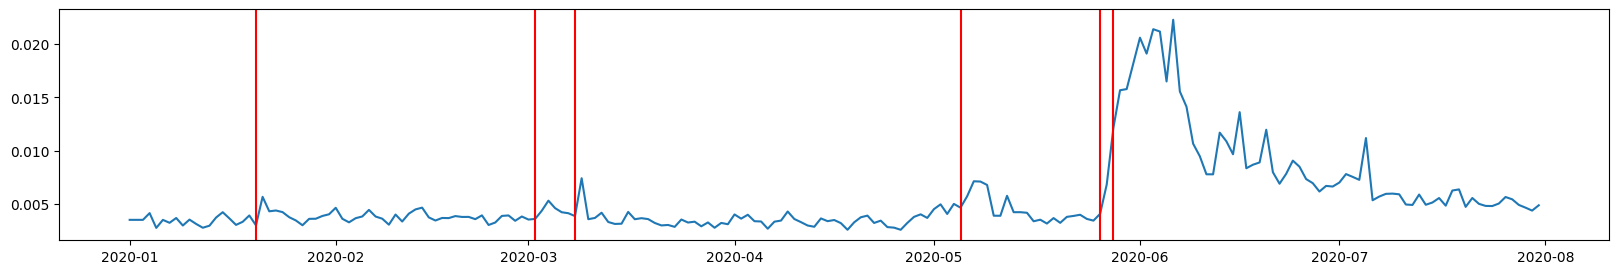

finalized change points:
2020-01-20 0.9999
2020-03-02 0.9997
2020-05-05 1.0
2020-05-26 0.9999
2020-06-21 0.7625


/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



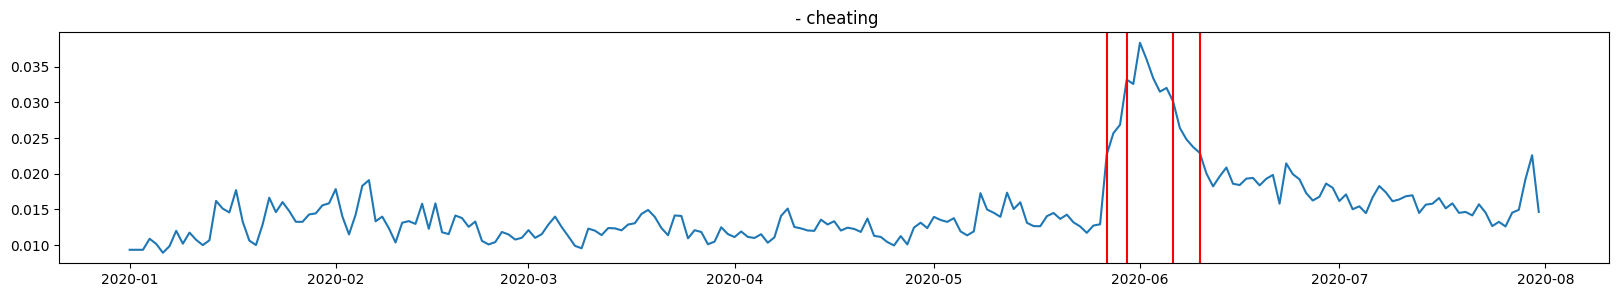

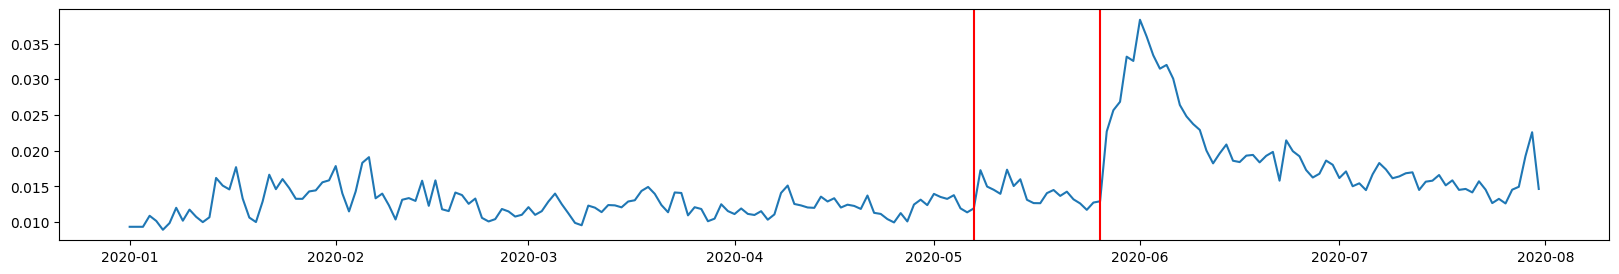

finalized change points:
2020-05-07 0.9988
2020-05-26 1.0


/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



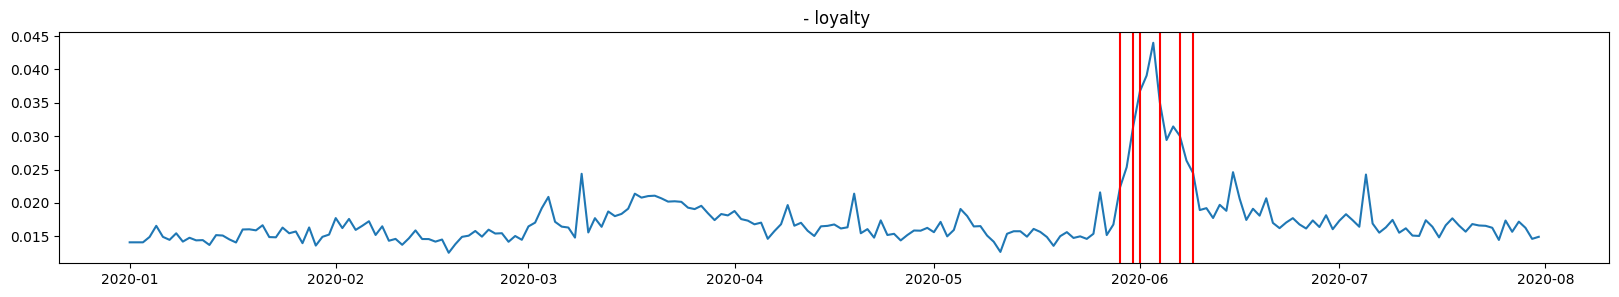

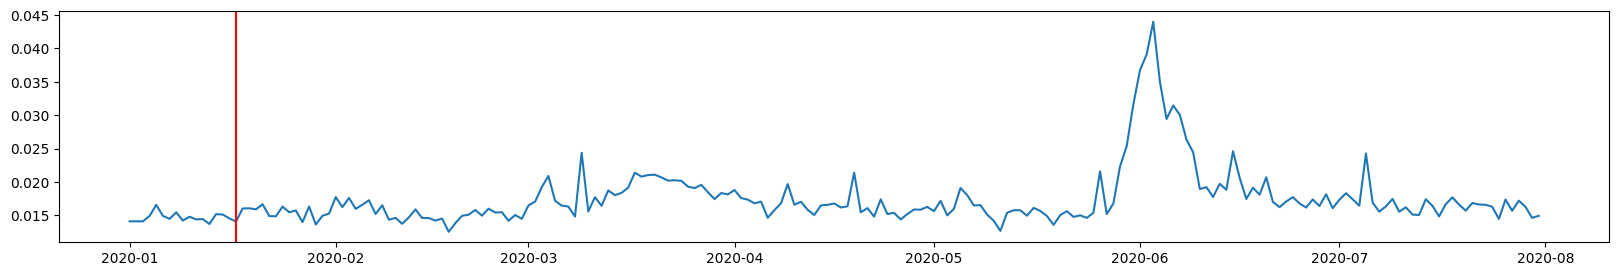

finalized change points:
2020-01-17 0.999
2020-05-29 0.8262


/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



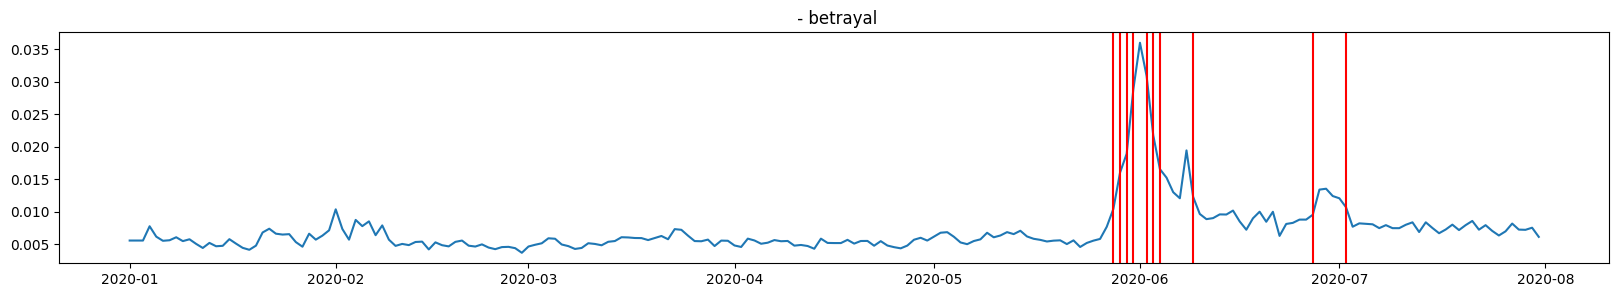

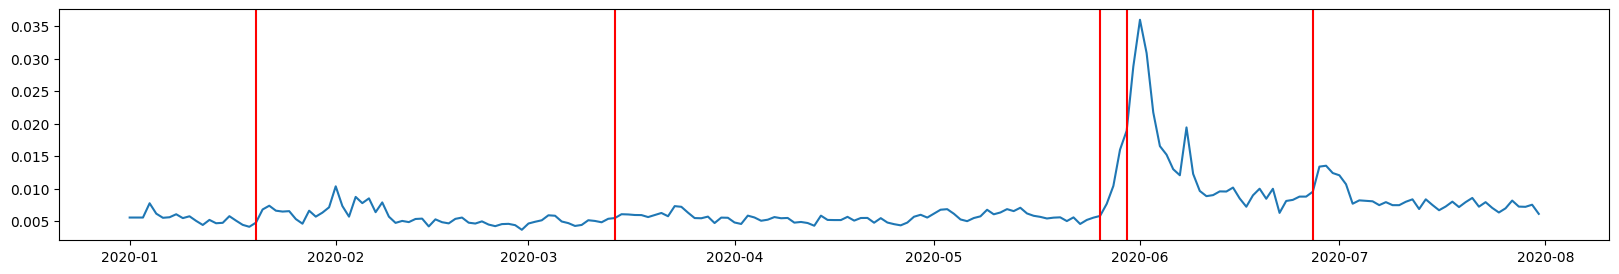

finalized change points:
2020-01-20 0.9999
2020-03-14 0.9937
2020-05-26 1.0
2020-06-27 0.6806


/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



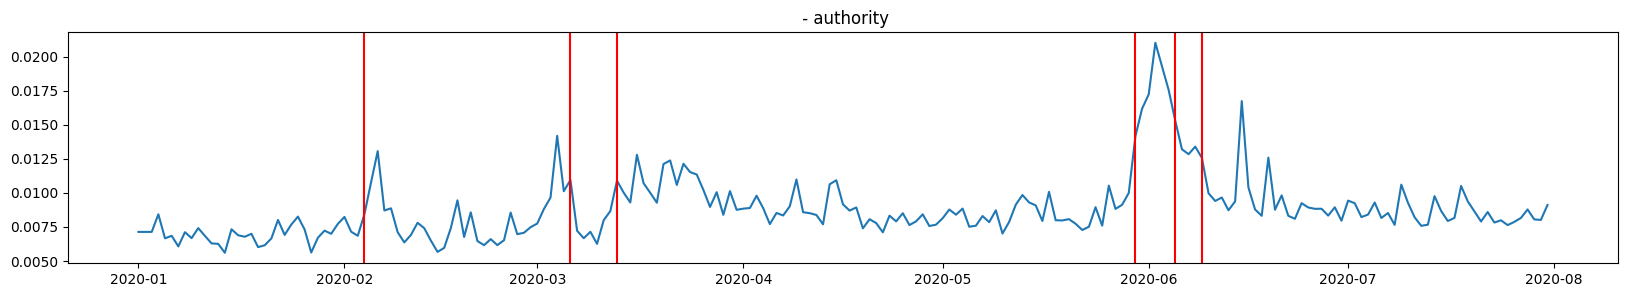

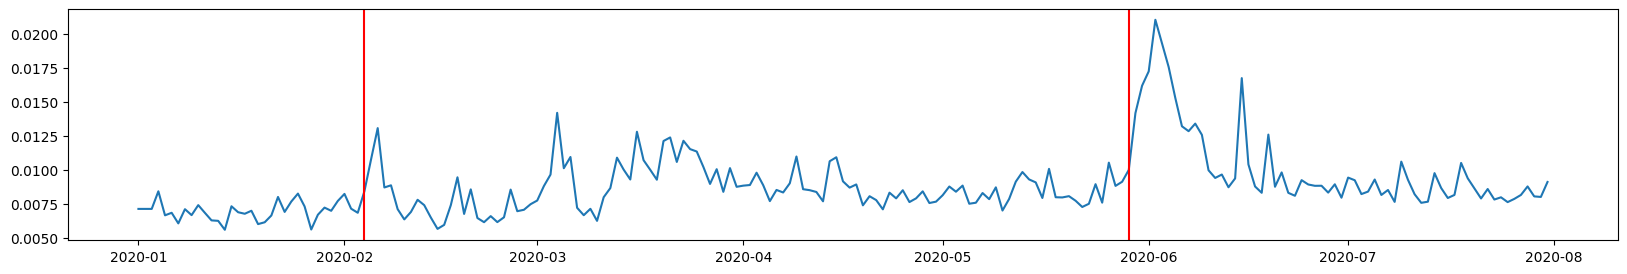

finalized change points:
2020-02-04 0.7109
2020-03-06 0.8738
2020-05-29 1.0


/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



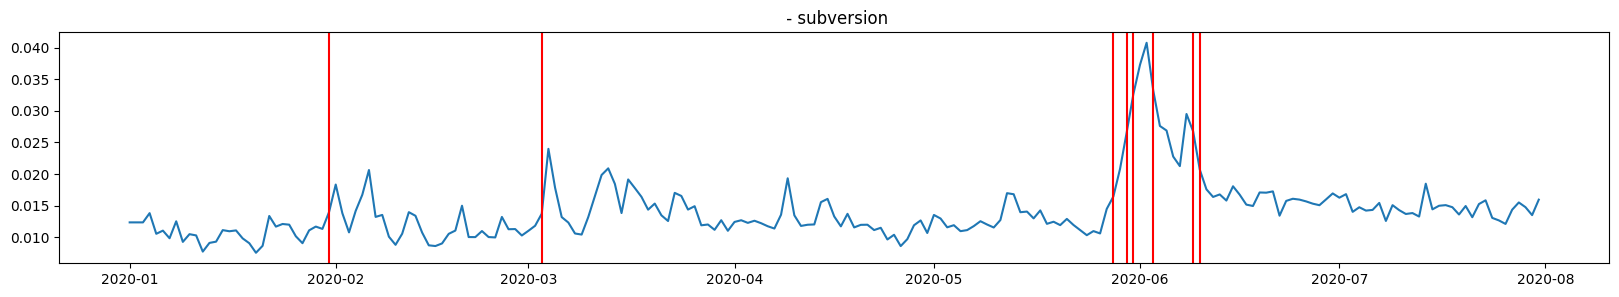

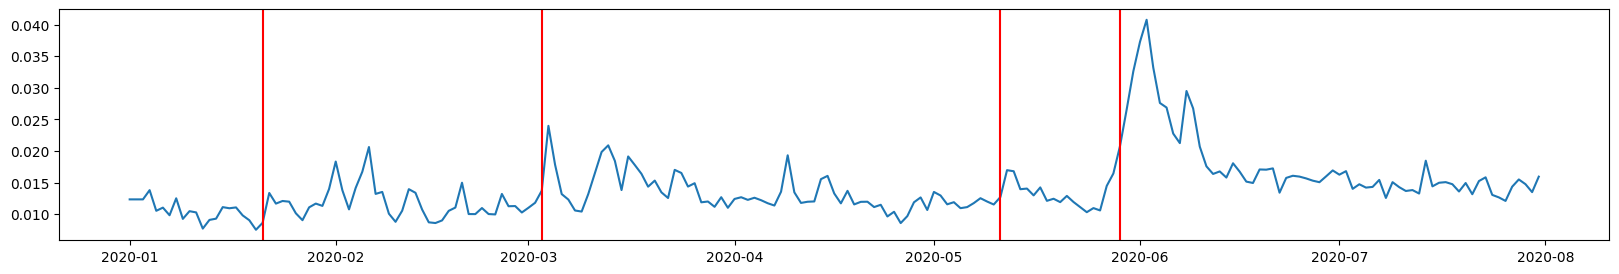

finalized change points:
2020-01-21 0.9941
2020-01-31 0.6244
2020-03-03 0.9178
2020-05-11 0.9994
2020-05-28 0.7284


/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



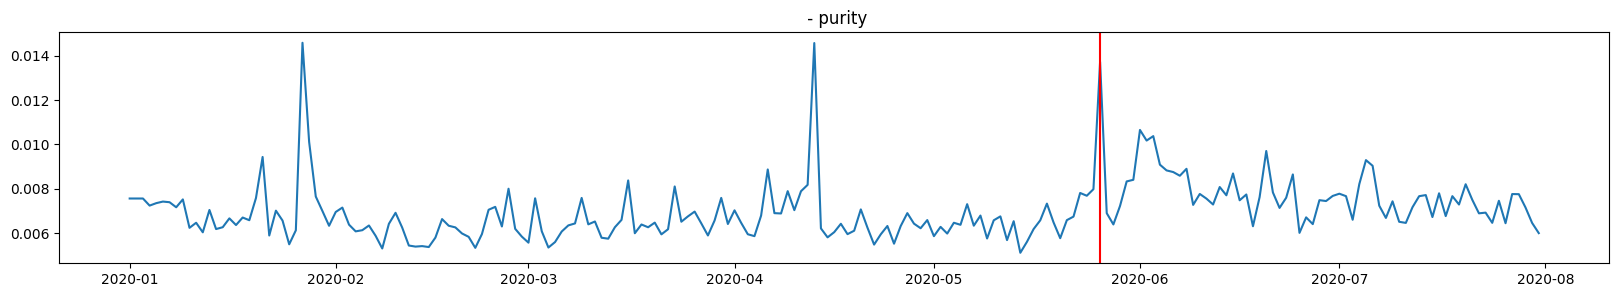

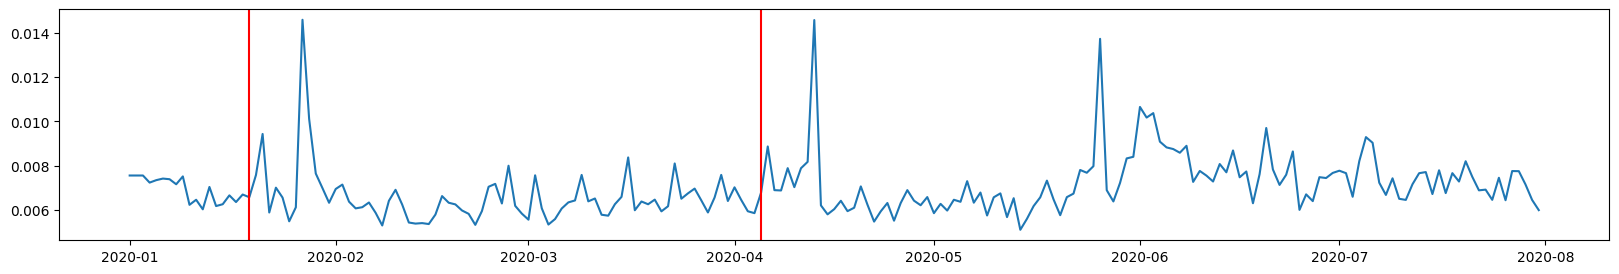

finalized change points:
2020-01-19 0.9945
2020-04-05 0.9982
2020-05-26 0.644


/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/fionaguo/.pyenv/versions/3.9.17/envs/cpd_env/lib/python3.9/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



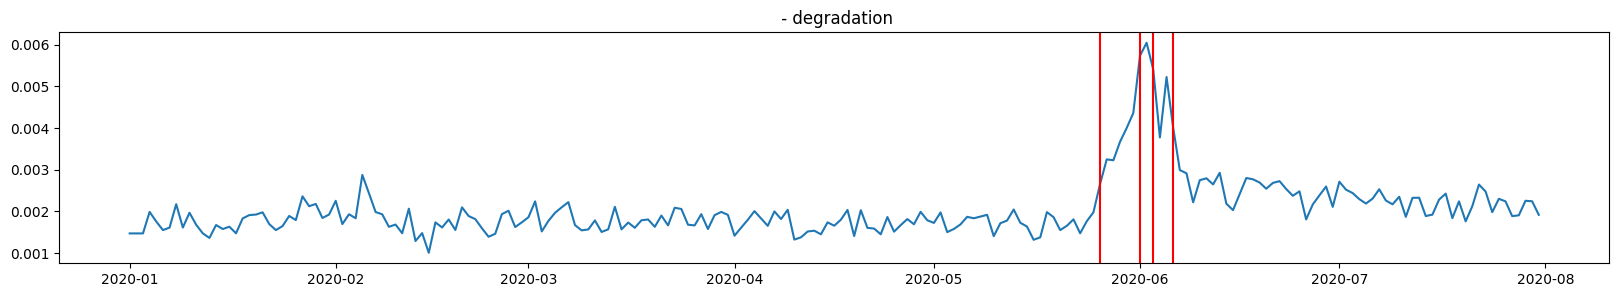

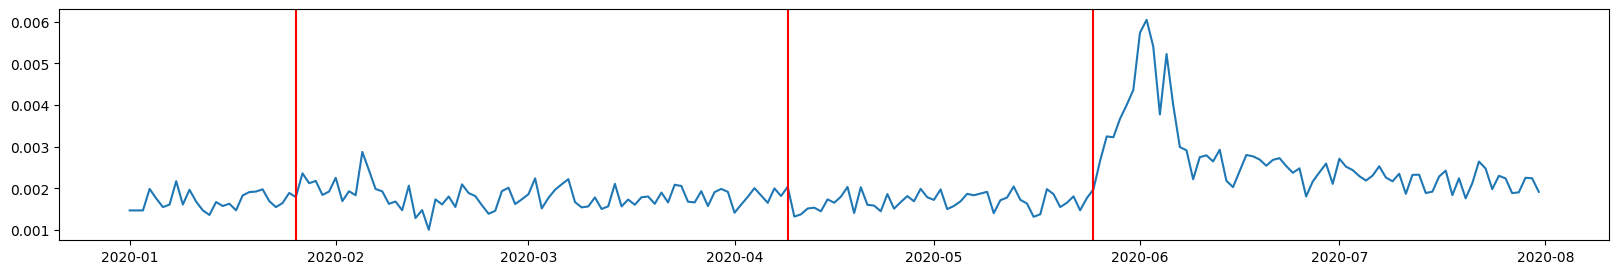

finalized change points:
2020-01-26 0.9996
2020-04-09 0.9989
2020-05-25 1.0


In [93]:
changepoints = changepoint_detection(df_daily.reset_index(),'date',emot_mf_colnames)

In [94]:
changepoints

{'anger': [(Timestamp('2020-02-03 00:00:00+0000', tz='UTC'),
   0.9997852890939275),
  (Timestamp('2020-03-10 00:00:00+0000', tz='UTC'), 0.9999604733682307),
  (Timestamp('2020-05-26 00:00:00+0000', tz='UTC'), 0.9999994198366198)],
 'anticipation': [(Timestamp('2020-01-26 00:00:00+0000', tz='UTC'),
   0.9797679118761915),
  (Timestamp('2020-03-13 00:00:00+0000', tz='UTC'), 0.7216528184576179),
  (Timestamp('2020-05-29 00:00:00+0000', tz='UTC'), 0.6947093460928353),
  (Timestamp('2020-06-09 00:00:00+0000', tz='UTC'), 0.6225250178015104)],
 'disgust': [(Timestamp('2020-02-03 00:00:00+0000', tz='UTC'),
   0.9999321102074497),
  (Timestamp('2020-02-14 00:00:00+0000', tz='UTC'), 0.6760945790746283),
  (Timestamp('2020-03-10 00:00:00+0000', tz='UTC'), 0.9999963347686506),
  (Timestamp('2020-05-26 00:00:00+0000', tz='UTC'), 0.9999987215634679),
  (Timestamp('2020-06-21 00:00:00+0000', tz='UTC'), 0.6124077624813743)],
 'fear': [(Timestamp('2020-03-11 00:00:00+0000', tz='UTC'),
   0.99999996675

In [97]:
with open('../LA_data/changepoints_LA.pkl','wb') as f:
    pickle.dump(changepoints,f)